# Customizing IPython - Magics

IPython extends Python by adding shell-like commands called **magics**.

In [1]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [2]:
import numpy

In [3]:
%timeit A=numpy.random.random((1000,1000))

7.16 ms ± 68.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%%timeit -n 1

A=numpy.random.random((1000,1000))
b = A.sum()


15.3 ms ± 2.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Defining your own magic

As we have seen already, IPython has cell and line magics. You can define your own magics using any Python function and the `register_magic_function` method:

In [5]:
ip = get_ipython()

In [6]:
import time

def sleep_magic(line):
    """A simple function for sleeping"""
    t = float(line)
    time.sleep(t)

In [7]:
ip.register_magic_function?

Signature: ip.register_magic_function(func, magic_kind='line', magic_name=None)
Docstring:
Expose a standalone function as magic function for IPython.

This will create an IPython magic (line, cell or both) from a
standalone function.  The functions should have the following
signatures: 

* For line magics: `def f(line)`
* For cell magics: `def f(line, cell)`
* For a function that does both: `def f(line, cell=None)`

In the latter case, the function will be called with `cell==None` when
invoked as `%f`, and with cell as a string when invoked as `%%f`.

Parameters
----------
func : callable
  Function to be registered as a magic.

magic_kind : str
  Kind of magic, one of 'line', 'cell' or 'line_cell'

magic_name : optional str
  If given, the name the magic will have in the IPython namespace.  By
  default, the name of the function itself is used.
File:      /usr/local/software/jureca/Stages/Devel-2019a/software/Jupyter/2019a-rc30-gcccoremkl-8.3.0-2019.3.199-Python-3.6.8/lib/python3.6/s

In [8]:
ip.register_magic_function(sleep_magic, "line", "sleep")

In [9]:
%sleep 2

In [10]:
%sleep?

Docstring: A simple function for sleeping
File:      /p/project/ccstvs/jupyter/j4j_notebooks/001-Tutorials/003-IPython-in-Depth/exercises/Customization/<ipython-input-6-2b120a0bad00>


### Exercise

Define `%tic` and `%toc` magics, which can be use for simple timings, e.g. where

```python
for p in range(1,4):
    N = 10**p
    print "N=%i" % N
    %tic
    A = np.random.random((N,N))
    np.linalg.eigvals(A)
    %toc
```

each `%toc` will print the time since the last `%tic`. Create separate `tic` and `toc` functions that read and write
a global time variable.

In [29]:
# %load soln/tictocf.py
import time

def format_time(dt):
    if dt < 1e-6:
        return u"%.3g ns" % (dt * 1e9)
    elif dt < 1e-3:
        return u"%.3g µs" % (dt * 1e6)
    elif dt < 1:
        return u"%.3g ms" % (dt * 1e3)
    else:
        return "%.3g s" % dt

def tic(line):
    global t0
    t0 = time.time()

def toc(line):
    global t0
    print (format_time(time.time() - t0))

ip = get_ipython()
ip.register_magic_function(tic)
ip.register_magic_function(toc)


In [30]:
import numpy as np
import sys
for p in range(1,4):
    N = 10**p
    print("N=%i" % N)
    sys.stdout.flush()
    %tic
    A = np.random.random((N,N))
    np.linalg.eigvals(A)
    %toc

N=10
1.14 ms
N=100
12.7 ms
N=1000
777 ms


### Cell Magic

**Cell magics** take two args:

1. the **line** on the same line of the magic 
2. the **cell** the multiline body of the cell after the first line

In [31]:
def dummy_cell_magic(line, cell):
    """dummy cell magic for displaying the line and cell it is passed"""
    print("line: %r" % line)
    print("cell: %r" % cell)

ip.register_magic_function(dummy_cell_magic, "cell", "dummy")

In [32]:
%%dummy this is the line
this
is the
cell

line: 'this is the line'
cell: 'this\nis the\ncell\n'


In [33]:
def parse_magic_line(line):
    """parse a magic line into a name and eval'd expression"""
    name, values_s = line.split(None, 1)
    values = eval(values_s, get_ipython().user_ns)
    return name, values

parse_magic_line("x range(5)")

('x', range(0, 5))

#### Excercise

Can you write and register a **cell magic** that automates the outer iteration,
timing a block for various values of a particular variable:

In [34]:
# %load soln/scalemagic.py
def scale_magic(line, cell):
    """run a cell block with a variety of input values"""
    name, values = parse_magic_line(line)
    ns = get_ipython().user_ns
    for v in values:
        assignment = "%s=%r" % (name, v)
        print(assignment)
        ns[name] = v
        sys.stdout.flush()
        %tic
        exec(cell, ns)
        %toc

ip = get_ipython()
ip.register_magic_function(scale_magic, "cell", "scale")


In [17]:
%%scale N [ int(10**p) for p in range(1,4) ]

A = np.random.random((N,N))
np.linalg.eigvals(A)


N=10
971 µs
N=100
12.8 ms
N=1000
785 ms


In [18]:
%%scale N [ int(2**p) for p in np.linspace(6, 11, 11) ]

A = np.random.random((N,N))
np.linalg.eigvals(A)


N=64
3.52 ms
N=90
8.31 ms
N=128
18.7 ms
N=181
55.7 ms
N=256
71.4 ms
N=362
118 ms
N=512
300 ms
N=724
396 ms
N=1024
904 ms
N=1448
1.34 s
N=2048
2.92 s


## Executing Notebooks

We can load a notebook into memory using `IPython.nbformat`.

In [19]:
import io
import os

import nbformat as nbf

In [20]:
def load_notebook(filename):
    """load a notebook object from a filename"""
    if not os.path.exists(filename) and not filename.endswith(".ipynb"):
        filename = filename + ".ipynb"
    with io.open(filename) as f:
        return nbf.read(f, as_version=4)


In [21]:
nb = load_notebook("_Sample")

**A notebook is just a dictionary** with attribute access for convenience.

In [22]:
nb.keys()

dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])

In [23]:
cells = nb.cells
cells

[{'cell_type': 'markdown', 'metadata': {}, 'source': '# A sample notebook'},
 {'cell_type': 'code',
  'execution_count': 1,
  'metadata': {'collapsed': False, 'jupyter': {'outputs_hidden': False}},
  'outputs': [{'name': 'stdout', 'output_type': 'stream', 'text': 'hello\n'}],
  'source': "print('hello')"},
 {'cell_type': 'code',
  'execution_count': 2,
  'metadata': {'collapsed': False, 'jupyter': {'outputs_hidden': False}},
  'outputs': [{'data': {'text/plain': '[<matplotlib.lines.Line2D at 0x2b3482c8a550>]'},
    'execution_count': 2,
    'metadata': {},
    'output_type': 'execute_result'},
   {'data': {'image/png': 'iVBORw0KGgoAAAANSUhEUgAAAXcAAAD8CAYAAACMwORRAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzsvWmQLNl1HvbdXKu6qvtt3e/N4L0ZzGDnAojLECRFmJtMEmSEg6ZCEaJEiTZlBQxLtBVeZNFhyQxLCoUYkkzKIcIMWrIo0jIR0EpIAgkKJEFABEFiQELAYDCDGQwwM2+Wt/fr7qquyu36R+a5efPmvblUZXVV9+QXMTHvdderysrl

We can see all the cells and their type

In [24]:
for cell in cells:
    print()
    print('----- %s -----' % cell.cell_type)
    print(cell.source)


----- markdown -----
# A sample notebook

----- code -----
print('hello')

----- code -----
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.random.random(100))

----- markdown -----
A function for displaying the summary of a notebook object.
It prints a simple summary, such as:

```
  1   markdown cells, total:   4 lines
  5       code cells, total:   4 lines
  1    heading cells, total:   1 lines
```

----- code -----
def nb_info(nb):
    """display a summary of the contents of a notebook"""
    cell_counts = {}
    cell_lines = {}
    
    for cell in nb.cells:
        cell_type = cell.cell_type
        count = cell_counts.setdefault(cell_type, 0)
        lines = cell_counts.setdefault(cell_type, 0)
        cell_counts[cell_type] = count + 1
        try:
            content = cell.source
        except AttributeError:
            content = cell.input
        cell_lines[cell_type] = lines + len(content.splitlines())
    
    for cell_type in cell_cou

Now I can run all of the **code cells** with `get_ipython().run_cell`

hello


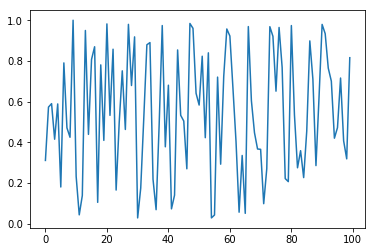

In [25]:
for cell in cells:
    ip = get_ipython()
    if cell.cell_type == 'code':
        ip.run_cell(cell.source, silent=True)

And we can now use the function that was defined in that notebook:

In [26]:
nb_info(nb)

  2   markdown cells, total:   9 lines
  4       code cells, total:   3 lines


### Exercise

Can you write and register an `%nbrun` line magic to run a notebook?

```python
%nbrun Sample
```

In [27]:
# %load soln/nbrun.py
def nbrun(line):
    """given a filename, execute the notebook in IPython"""
    nb = load_notebook(line)
    ip = get_ipython()
    for cell in nb.cells:
        if cell.cell_type == 'code':
            ip.run_cell(cell.source, silent=True)
    
get_ipython().register_magic_function(nbrun)


hello


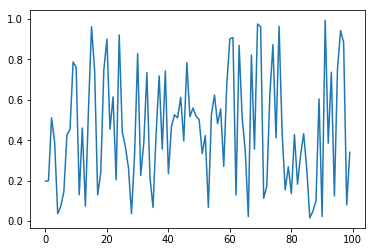

In [28]:
%nbrun _Sample

The common way to make your magics reusable is to [write an Extension](Customizing%20IPython%20-%20Extensions.ipynb), so let's give that a try.